In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

import shap
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import squareform


# INTRODUZIONE

Il Wine Quality è un dataset presente nella UCI machine learning repository.

Le varie features che lo compongono sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di "vinho verde", un vino rosso del portogallo, volti a determinarne la qualità. 

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.

# IMPORTAZIONE DATABASE REDWINE

Si inizia con l' importare il database, convertendolo da csv a pandas dataframe

In [2]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';')
red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Si procede con il controllo della distribuzione della colonna 'quality'. A tale scopo, viene generata una palette personalizzata composta da sfumature di arancione per segnalare i campioni di vino al di sotto della media, e sfumature di verde per identificare i vini di qualità superiore.

,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


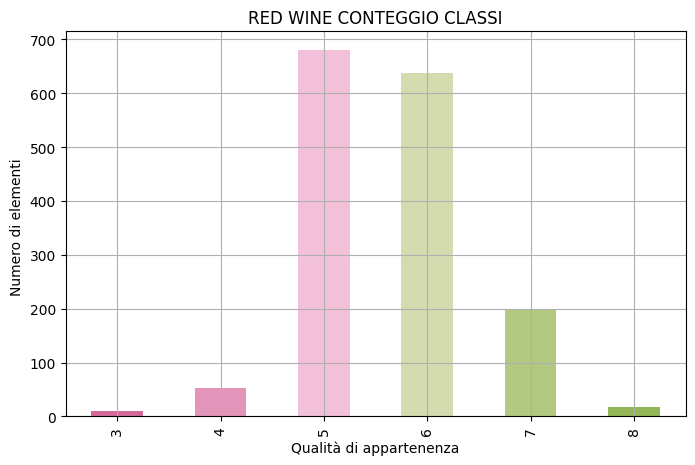

In [3]:
# Si selezionano delle tonalità di rosso e verde colorblind friendly
red_color = '#b51963'
green_color = '#5ba300'

# Tramite light_palette si creano sfumature dei colori selezionati che vengono manualmente 
# modificate per aumentarne la luminosità ed evitare colori troppo chiari
red_palette = sns.light_palette(red_color, n_colors=5, reverse=True)
red_palette = [(c[0], c[1]*0.8, c[2]*0.9) for c in red_palette]
green_palette = sns.light_palette(green_color, n_colors=5)
green_palette = [(c[0] * 0.9, c[1]*0.9, c[2] * 0.75) for c in green_palette]
custom_palette = red_palette + green_palette

# Si procede con il selezionare i valori unici della colonna 'quality' e creare un dizionario per i colori
quality_unique_values = np.unique(red_wine['quality'].values)
colors_mapping = dict(zip(np.arange(10)+1, custom_palette))

# Creazione di un dataset contenente i conteggi dei diversi livelli di qualità dei vari campioni e le loro frequenze
N = red_wine.shape[0]
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts() / N], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)
display(class_cont_freq)

# Un plot per mostrare la distribuzione della qualità dei vini, utilizzando la palette personalizzata
plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8, 5), color=[colors_mapping[q] for q in class_cont_freq.index])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# PROBLEMA BINARIO

Il problema di multiclassificazione viene diviso in un problema binario accorpando le classi.

In [4]:
red_wine['quality'].replace([3, 4, 5], value=0, inplace=True)
red_wine['quality'].replace([6, 7, 8], value=1, inplace=True)

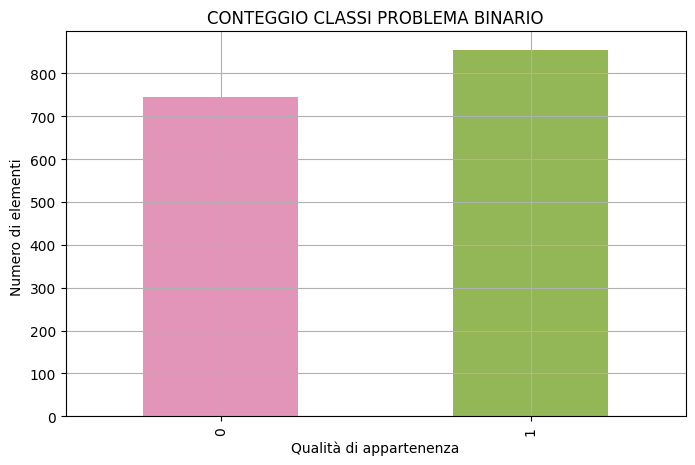

In [5]:
plt.figure()
red_wine['quality'].value_counts().sort_values().plot.bar(figsize=(8,5), color=[custom_palette[3], custom_palette[7]])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()

# CREAZIONE TRAINING, VALIDATION E TEST SET

In [6]:
X = red_wine.iloc[:, :-1] 
y = red_wine['quality']
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 246120
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

# GRID SEARCH
Si crea una Pipeline contenente uno Standard Scaler e una SVC. La pipeline viene poi passata ad una GridSearchCV per fare una ottimizzazione degli iperparametri

In [7]:

n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler().set_output(transform="pandas")),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X, y)



Fitting 1 folds for each of 60 candidates, totalling 60 fits


GridSearchCV(cv=<zip object at 0x0000018EE6D77A00>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svc__C': [0.25, 0.5, 1, 2, 4],
                         'svc__gamma': [0.18181818181818182,
                                        0.09090909090909091,
                                        0.06060606060606061],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_weighted', verbose=True)

In [8]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
40,0.047996,0.0,0.015090,0.0,2,0.090909,rbf,"{'svc__C': 2, 'svc__gamma': 0.0909090909090909...",0.772658,0.772658,0.0,1,0.828988,0.828988,0.0
44,0.055905,0.0,0.013003,0.0,2,0.060606,rbf,"{'svc__C': 2, 'svc__gamma': 0.0606060606060606...",0.766430,0.766430,0.0,2,0.805956,0.805956,0.0
28,0.046004,0.0,0.013995,0.0,1,0.090909,rbf,"{'svc__C': 1, 'svc__gamma': 0.0909090909090909...",0.766430,0.766430,0.0,2,0.803886,0.803886,0.0
56,0.045923,0.0,0.012095,0.0,4,0.060606,rbf,"{'svc__C': 4, 'svc__gamma': 0.0606060606060606...",0.766356,0.766356,0.0,4,0.826889,0.826889,0.0
48,0.051995,0.0,0.015988,0.0,4,0.181818,rbf,"{'svc__C': 4, 'svc__gamma': 0.1818181818181818...",0.766154,0.766154,0.0,5,0.916560,0.916560,0.0
24,0.049092,0.0,0.014911,0.0,1,0.181818,rbf,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.763196,0.763196,0.0,6,0.854014,0.854014,0.0
36,0.053896,0.0,0.016082,0.0,2,0.181818,rbf,"{'svc__C': 2, 'svc__gamma': 0.1818181818181818...",0.763094,0.763094,0.0,7,0.885295,0.885295,0.0
52,0.048004,0.0,0.013001,0.0,4,0.090909,rbf,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.760031,0.760031,0.0,8,0.868607,0.868607,0.0
12,0.056015,0.0,0.016000,0.0,0.5,0.181818,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.18181818181818...",0.759918,0.759918,0.0,9,0.826850,0.826850,0.0
32,0.047002,0.0,0.014998,0.0,1,0.060606,rbf,"{'svc__C': 1, 'svc__gamma': 0.0606060606060606...",0.757051,0.757051,0.0,10,0.795459,0.795459,0.0


Il best_estimator viene riallenato sul training set e messo poi alla prova su validation e test set. In questa parte si calcolano le varie metriche per valutare le performance del modello

In [9]:
best_model = svm_gs.best_estimator_.fit(X.iloc[ind_train, :], y.iloc[ind_train])

y_pred_train = svm_gs.best_estimator_.predict(X.iloc[ind_train, :])
y_true_train = y.iloc[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X.iloc[ind_val, :])
y_true_val = y.iloc[ind_val]

y_pred = svm_gs.best_estimator_.predict(X.iloc[ind_test, :])
y_true = y.iloc[ind_test]

acc_train = svm_gs.best_estimator_.score(X.iloc[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X.iloc[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X.iloc[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

,Accuracy,Precision,Recall,F1
training,0.828810,0.830581,0.828810,0.828988
validation,0.771875,0.784453,0.771875,0.772658
test,0.746250,0.746923,0.746250,0.746389


,classe 0,classe 1
classe 0,285,95
classe 1,108,312


,classe 0,classe 1
classe 0,0.750000,0.250000
classe 1,0.257143,0.742857


,classe 0,classe 1
classe 0,0.725191,0.233415
classe 1,0.274809,0.766585


# SHAP

Nonostante SHAP sia in grado di gestire una Pipeline, per ottimizzare la velocità dell'explainer, si è scelto di estrarre lo scaler e la SVC dal miglior estimatore. In questo modo, i valori di SHAP vengono calcolati direttamente utilizzando il modello e i dati scalati.

In [10]:
scaler = best_model.named_steps['scaler']
svm_model = best_model.named_steps['svc']

X_train = scaler.transform(X.iloc[ind_train])
X_test = scaler.transform(X.iloc[ind_test])

# Come background data si estraggono in maniera casuale 100 campioni dal training set
background_data = shap.sample(X_train, nsamples=100, random_state=246120)
# Si calcola manualmente la media delle previsioni del modello sui campioni del background
base_values = np.full(background_data.shape[0], svm_model.predict(background_data).mean())

# Come Explainer si è scelto di usare il Permutation vista la sua maggiore velocità in confronto al Kernel Explainer
Permutation_explainer = shap.explainers.Permutation(svm_model.predict, background_data, seed=246120)

# Invece che chiamare direttamente il Permutation sul Test set, si è preferito usare il metodo .shap_values
# Questo significa dover manualmente creare un Explanation Object da utilizzare nei vari Plot
# Tale approccio è leggermente più veloce della sua controparte 
shap_values_Perm = Permutation_explainer.shap_values(X_test)
shap_explanation_Perm = shap.Explanation(shap_values_Perm, base_values, X_test.values, feature_names=X_test.columns)


PermutationExplainer explainer: 801it [08:31,  1.53it/s]                           


### WATERFALL PLOT

Vengono stampati i waterfall plot di alcune stanze per confrontare i vari grafici

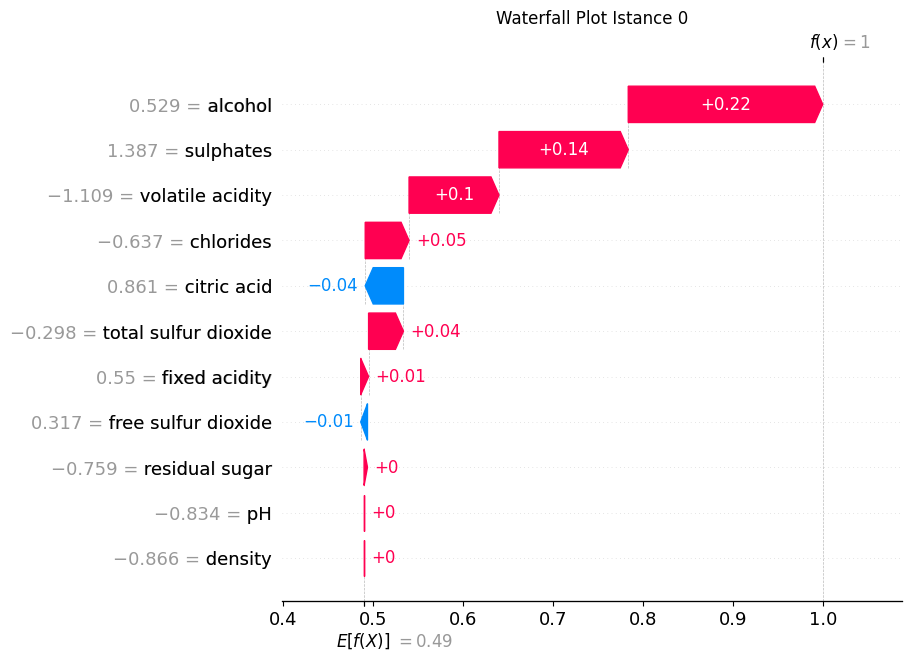

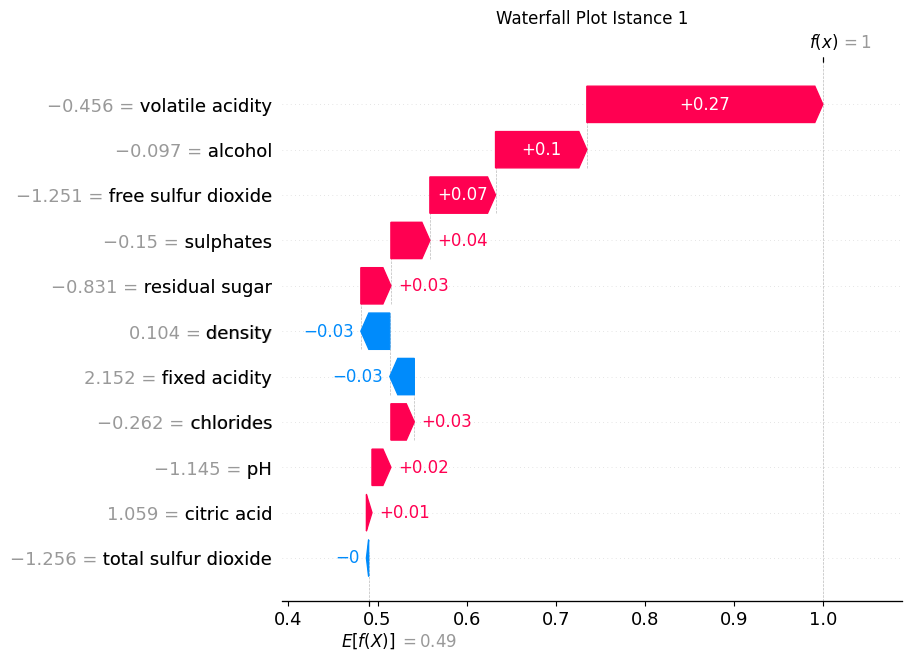

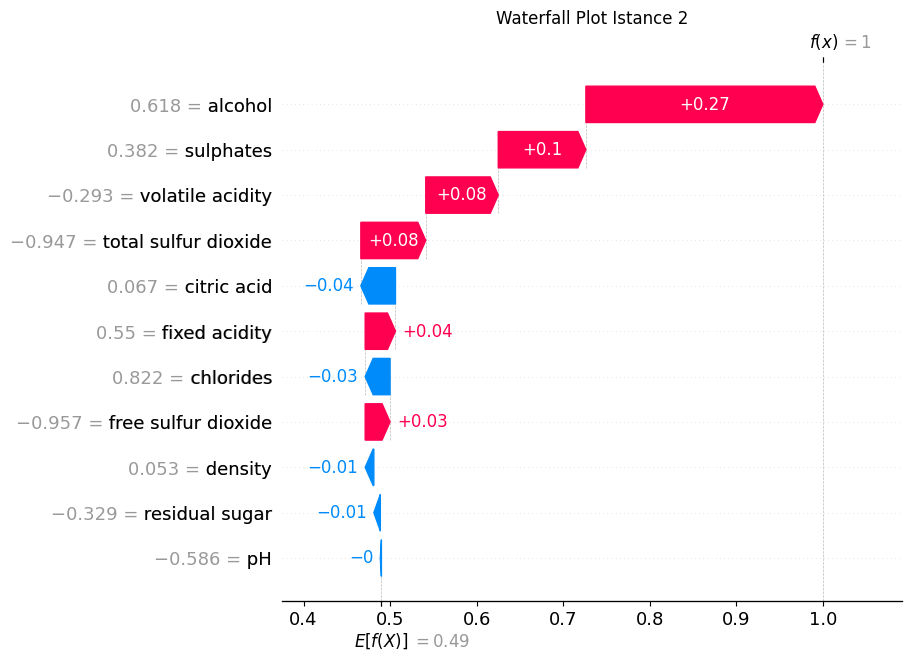

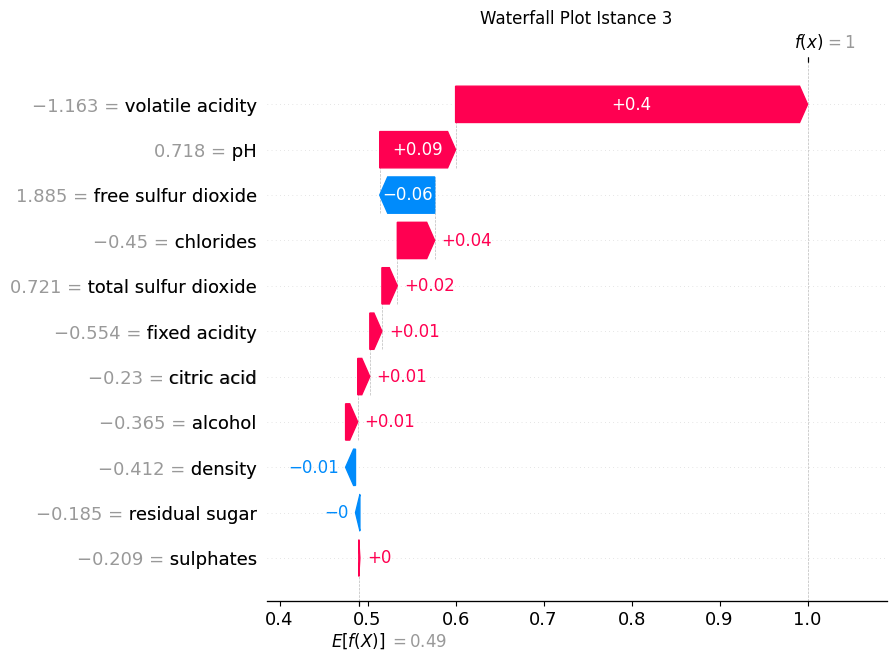

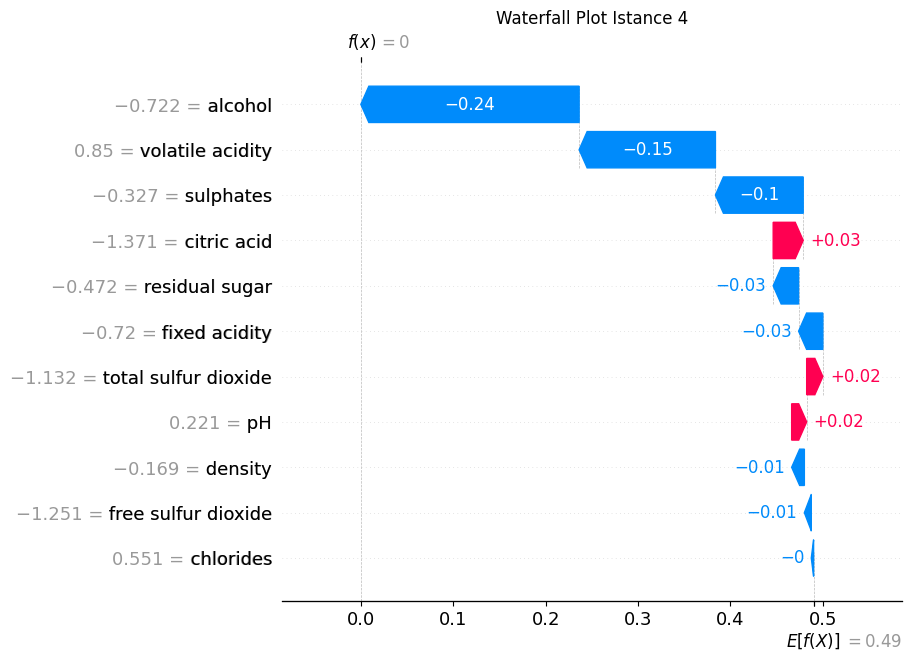

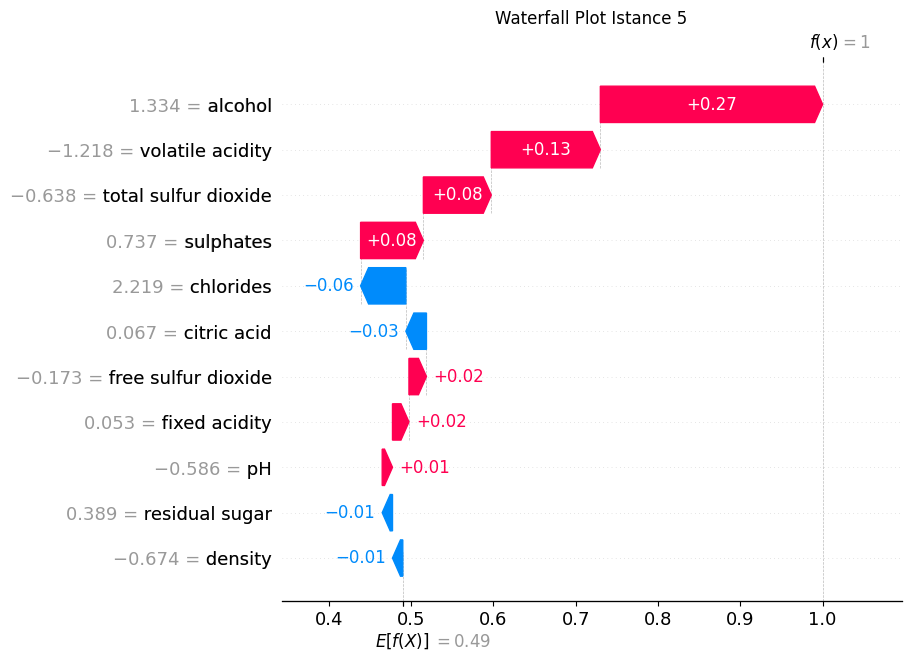

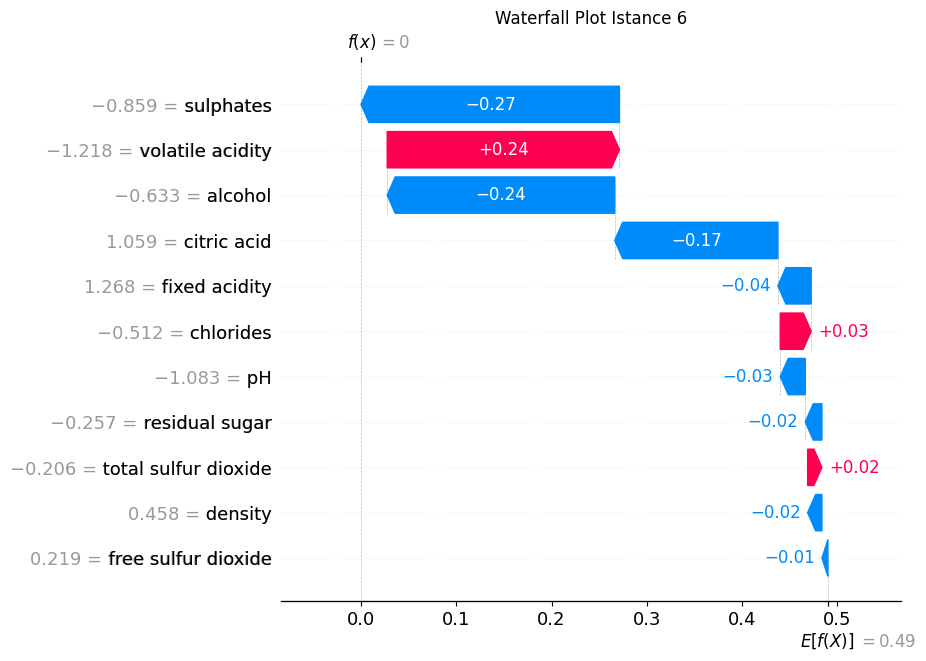

In [11]:
for i in range(7):
    fig = plt.figure()
    shap.plots.waterfall(shap_explanation_Perm[i], max_display=X_test.shape[1], show=False)
    plt.title(f'Waterfall Plot Istance {i}')


plt.show()
plt.close()


### FORCE PLOT

In [12]:
shap.initjs() # questo comando serve per attivare il framework javascript 
shap.plots.force(shap_explanation_Perm[0])

### SUMMARY PLOT

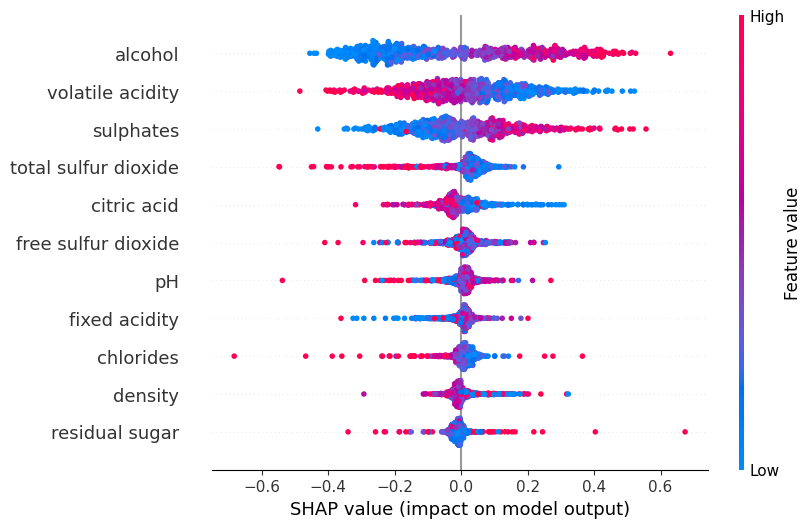

In [13]:
shap.plots.beeswarm(shap_explanation_Perm, max_display=X_test.shape[1])

### DEPENDENCE PLOT

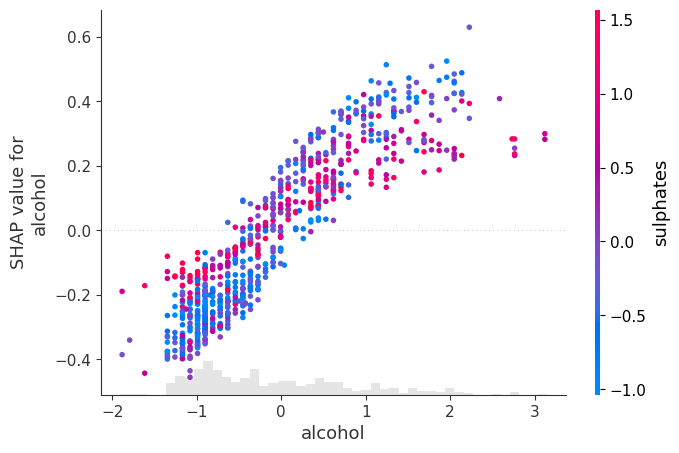

In [14]:
shap.plots.scatter(shap_explanation_Perm[:, 'alcohol'], color=shap_explanation_Perm)


# PROBLEMA DI CORRELAZIONE

Applicazione del Permutation Explainer per risolvere il problema della correlazione delle feature

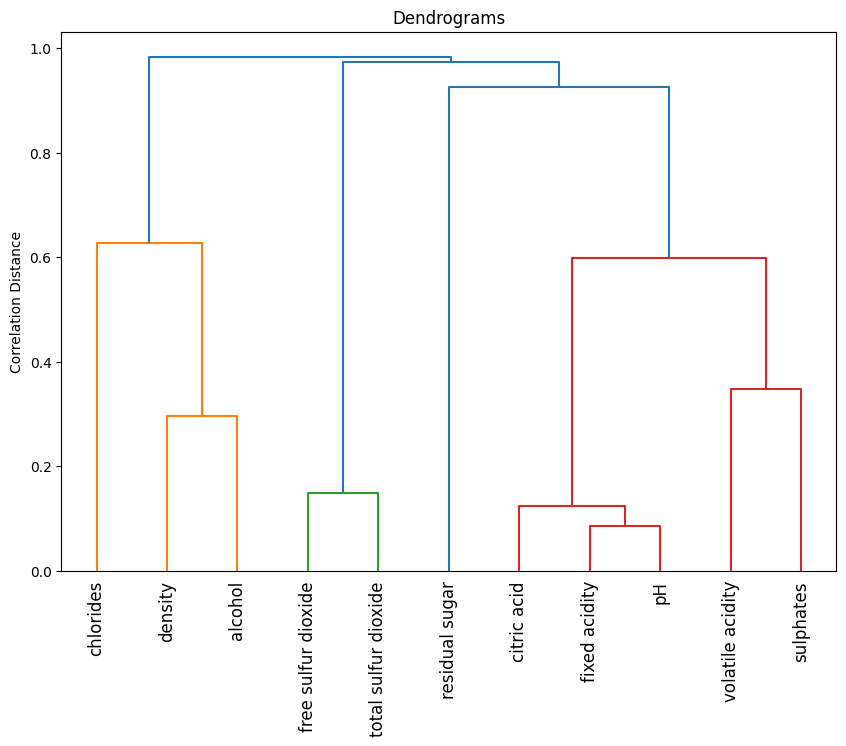

In [15]:
correlation_matrix = X_train.corr()

# corrcoef crea la matrice contenente le correlazioni di Pearson
correlation_matrix = np.corrcoef(correlation_matrix)

# Per errori di macchina tale matrice non è sempre simmetrica e i termini della diagonale possono non essere uguali ad 1
correlation_matrix = (correlation_matrix + correlation_matrix.T)/2
np.fill_diagonal(correlation_matrix, 1) 
 
# Correlazioni negative forte devono essere considerate. Quindi si utilizza la correlazione assoluta
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix

# La matrice distanza deve essere compressa
compressed_dist_matrix = squareform(dist_matrix)

# Utilizzando linkage di scipy si effettua il clustering delle features
clustering = sch.linkage(compressed_dist_matrix, method="complete")

plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = sch.dendrogram(clustering, labels=X_train.columns)
plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()
plt.close()


Si ripete l'allenamento della SVM, passando alla GridSearch solo i .values del dataset. Il risultato è lo stesso, tale passaggio viene fatto per evitare dei messaggi di warning, visto che, in caso contrario, il modello si aspetta i nomi delle features. Il Partition marker, infatti, non sembra riuscire a passare tali nomi quando chiama il modello per ottenere le previsioni

In [16]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]), verbose=True)

svm_gs.fit(X.values, red_wine['quality'].values)

best_model = svm_gs.best_estimator_.fit(X.iloc[ind_train, :].values, y.iloc[ind_train].values)
svm_model = best_model.named_steps['svc']


Fitting 1 folds for each of 60 candidates, totalling 60 fits


Creazione del Partition Masker che raggruppa le features in base alla correlazione

In [17]:
masker = shap.maskers.Partition(X_train.values, clustering=clustering)
Partition_Explainer = shap.PartitionExplainer(svm_model.predict, masker, feature_names=X_train.columns)
shap_values_Part = Partition_Explainer(X_test.values)

PartitionExplainer explainer: 801it [11:16,  1.16it/s]                         


Bar plot per confrontare i valori delle importanze delle feature trovati dal Permutation Explainer e dal Partition Explainer

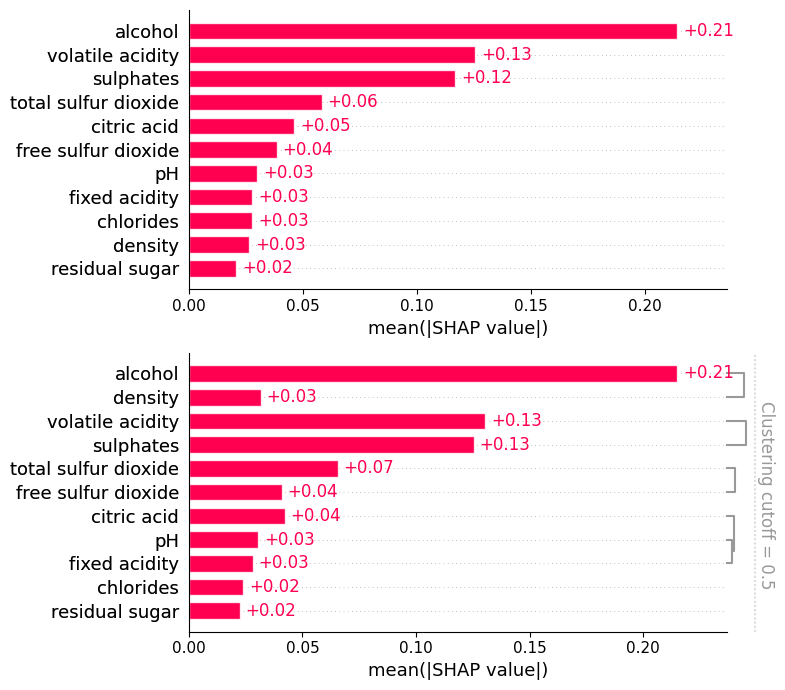

In [18]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_explanation_Perm, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(shap_values_Part, max_display=11, show=False, clustering_cutoff=0.5)
plt.tight_layout()
plt.show()
